In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import cv2, glob, os, pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Utilities.Undistort import *
from Utilities.Perspective_Transform import *
from Utilities.Binarize import *

In [3]:
images = glob.glob('../Lane Images/*.jpg')

In [4]:
def undistort(image):
    '''
    -> Return an undistorted Image
    -> (param) : An RGB/BGR Image
    -> (return): An undestorted RGB/BGR Image
    '''
    undistorter = Undistort(image)
    return undistorter.process()

In [5]:
def perspective_transform(image):
    '''
    -> Return a Perspective Transformed Image
    -> (param) : An RGB/BGR Image, ideally undistorted
    -> (return): An RGB/BGR Image, ideally Perspective Transformed
    '''
    perspective_transformer = Perspective_Transform(image)
    warped, warped_labelled, roi, image_labelled = perspective_transformer.process()
    return warped, warped_labelled, roi, image_labelled

In [6]:
def binarize(image):
    '''
    -> Return a Binarized Image
    -> (param) : An RGB/BGR Image, ideally Perspective Transformed
    -> (return): A Binary Image consisting the lane pixels as set bits
    '''
    binarize = Binarize(warped)
    binarized_image = binarize.process()
    return binarized_image

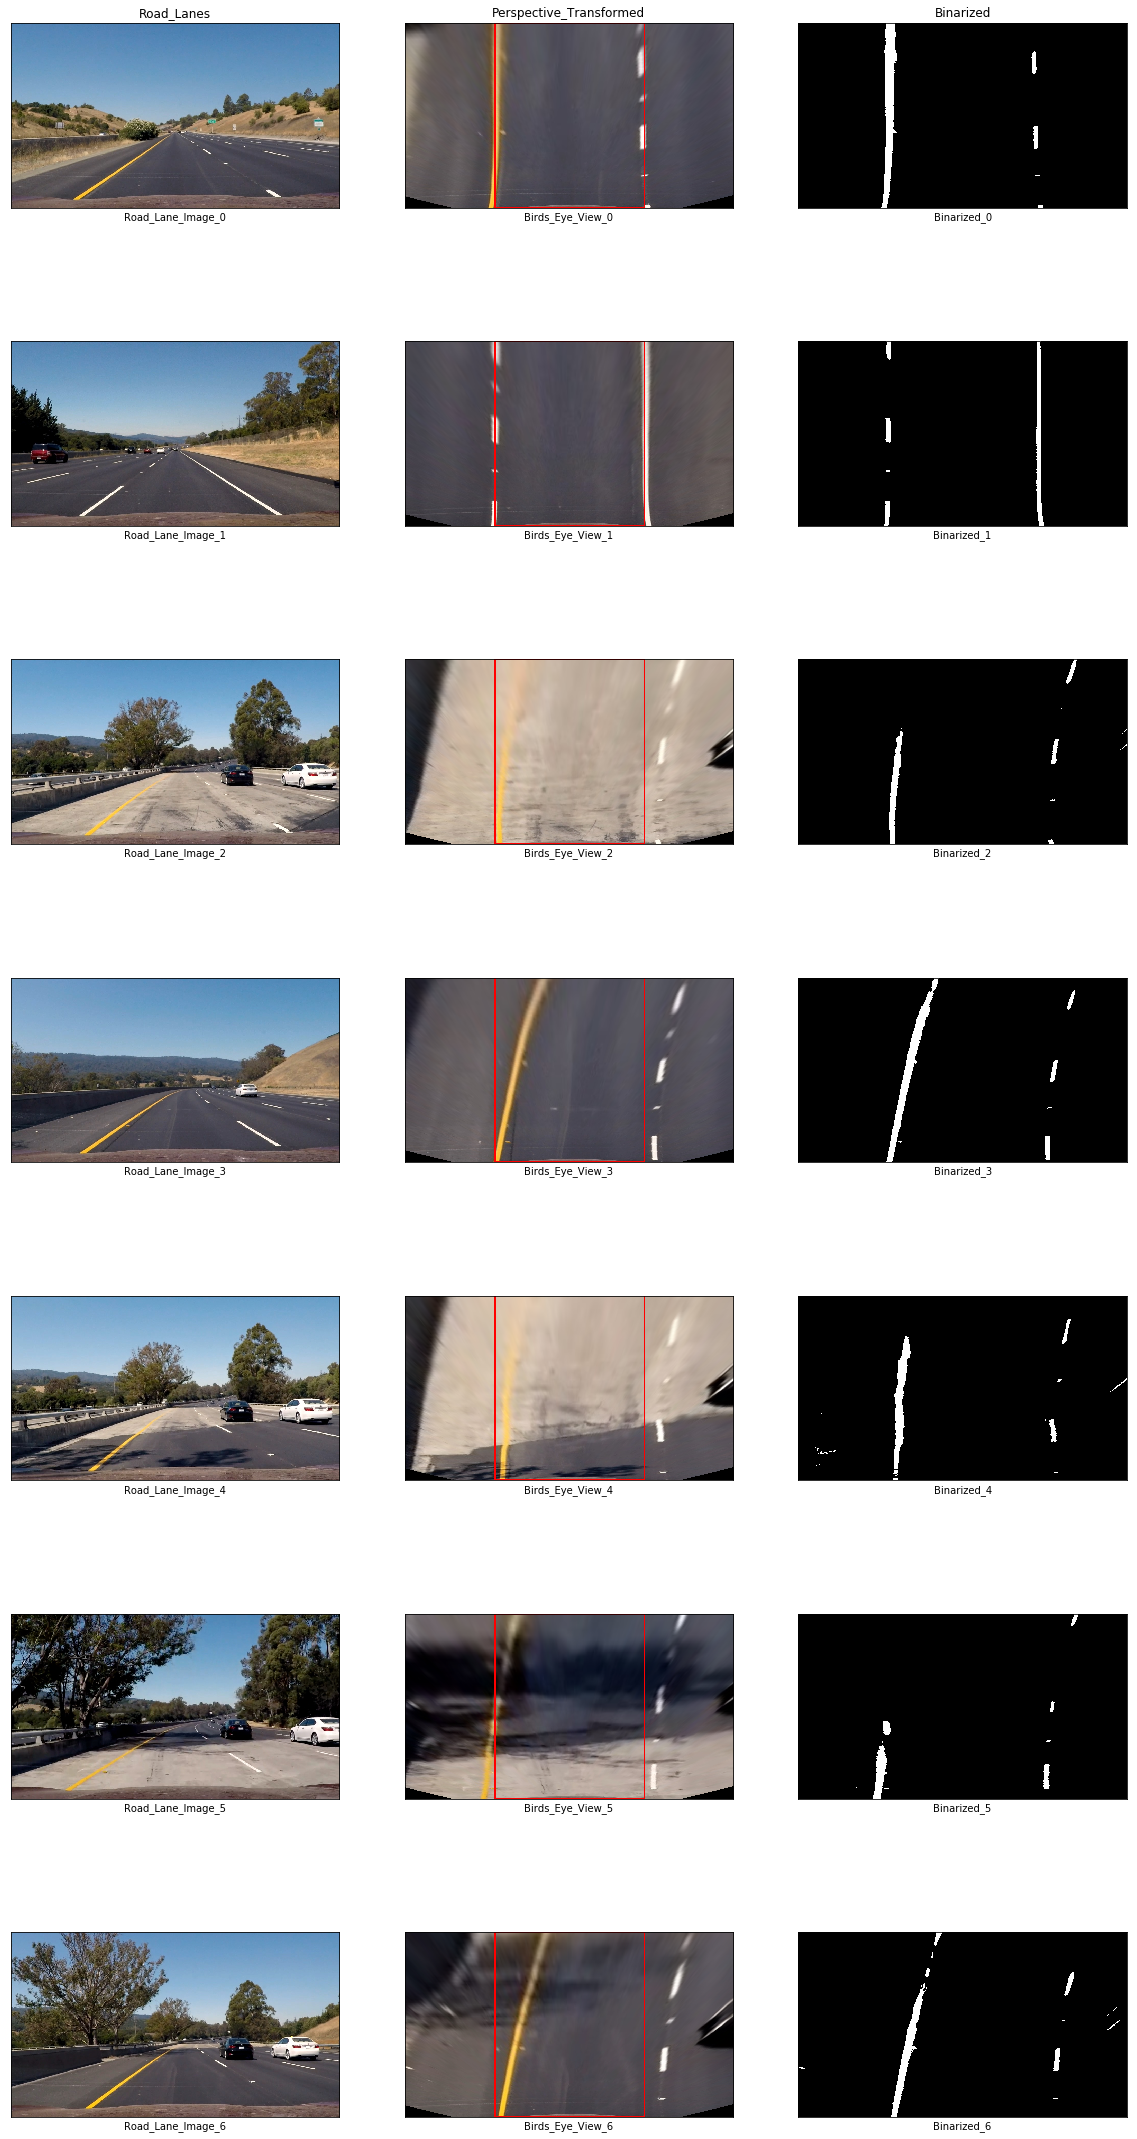

In [7]:
fig, axes = plt.subplots(nrows = len(images), ncols = 3, figsize = (20, 40))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for ax, col in zip(axes[0], ['Road_Lanes', 'Perspective_Transformed', 'Binarized']):
    ax.set_title(col)
for i, ax in enumerate(axes.flat):
    image = mpimg.imread(images[c])
    undistorted = undistort(image)
    warped, warped_labelled, roi, image_labelled = perspective_transform(undistorted)
    binarized = binarize(warped)
    if i % 3 == 0:
        ax.imshow(image)
        ax.set_xlabel('Road_Lane_Image_' + str(c))
    if i % 3 == 1:
        ax.imshow(warped_labelled)
        ax.set_xlabel('Birds_Eye_View_' + str(c))
    if i % 3 == 2:
        ax.imshow(binarized, cmap = 'gray')
        ax.set_xlabel('Binarized_' + str(c))
        c += 1
plt.show()

In [8]:
SHAPE = (720, 1280)

In [9]:
def get_histogram(image):
    return np.sum(image[image.shape[0] // 2 :, :], axis = 0)

In [10]:
def get_histogram_peaks(histogram):
    middle = np.int(histogram.shape[0] / 2)
    left_peak = np.argmax(histogram[ : middle])
    right_peak = np.argmax(histogram[middle : ]) + middle
    return left_peak, right_peak

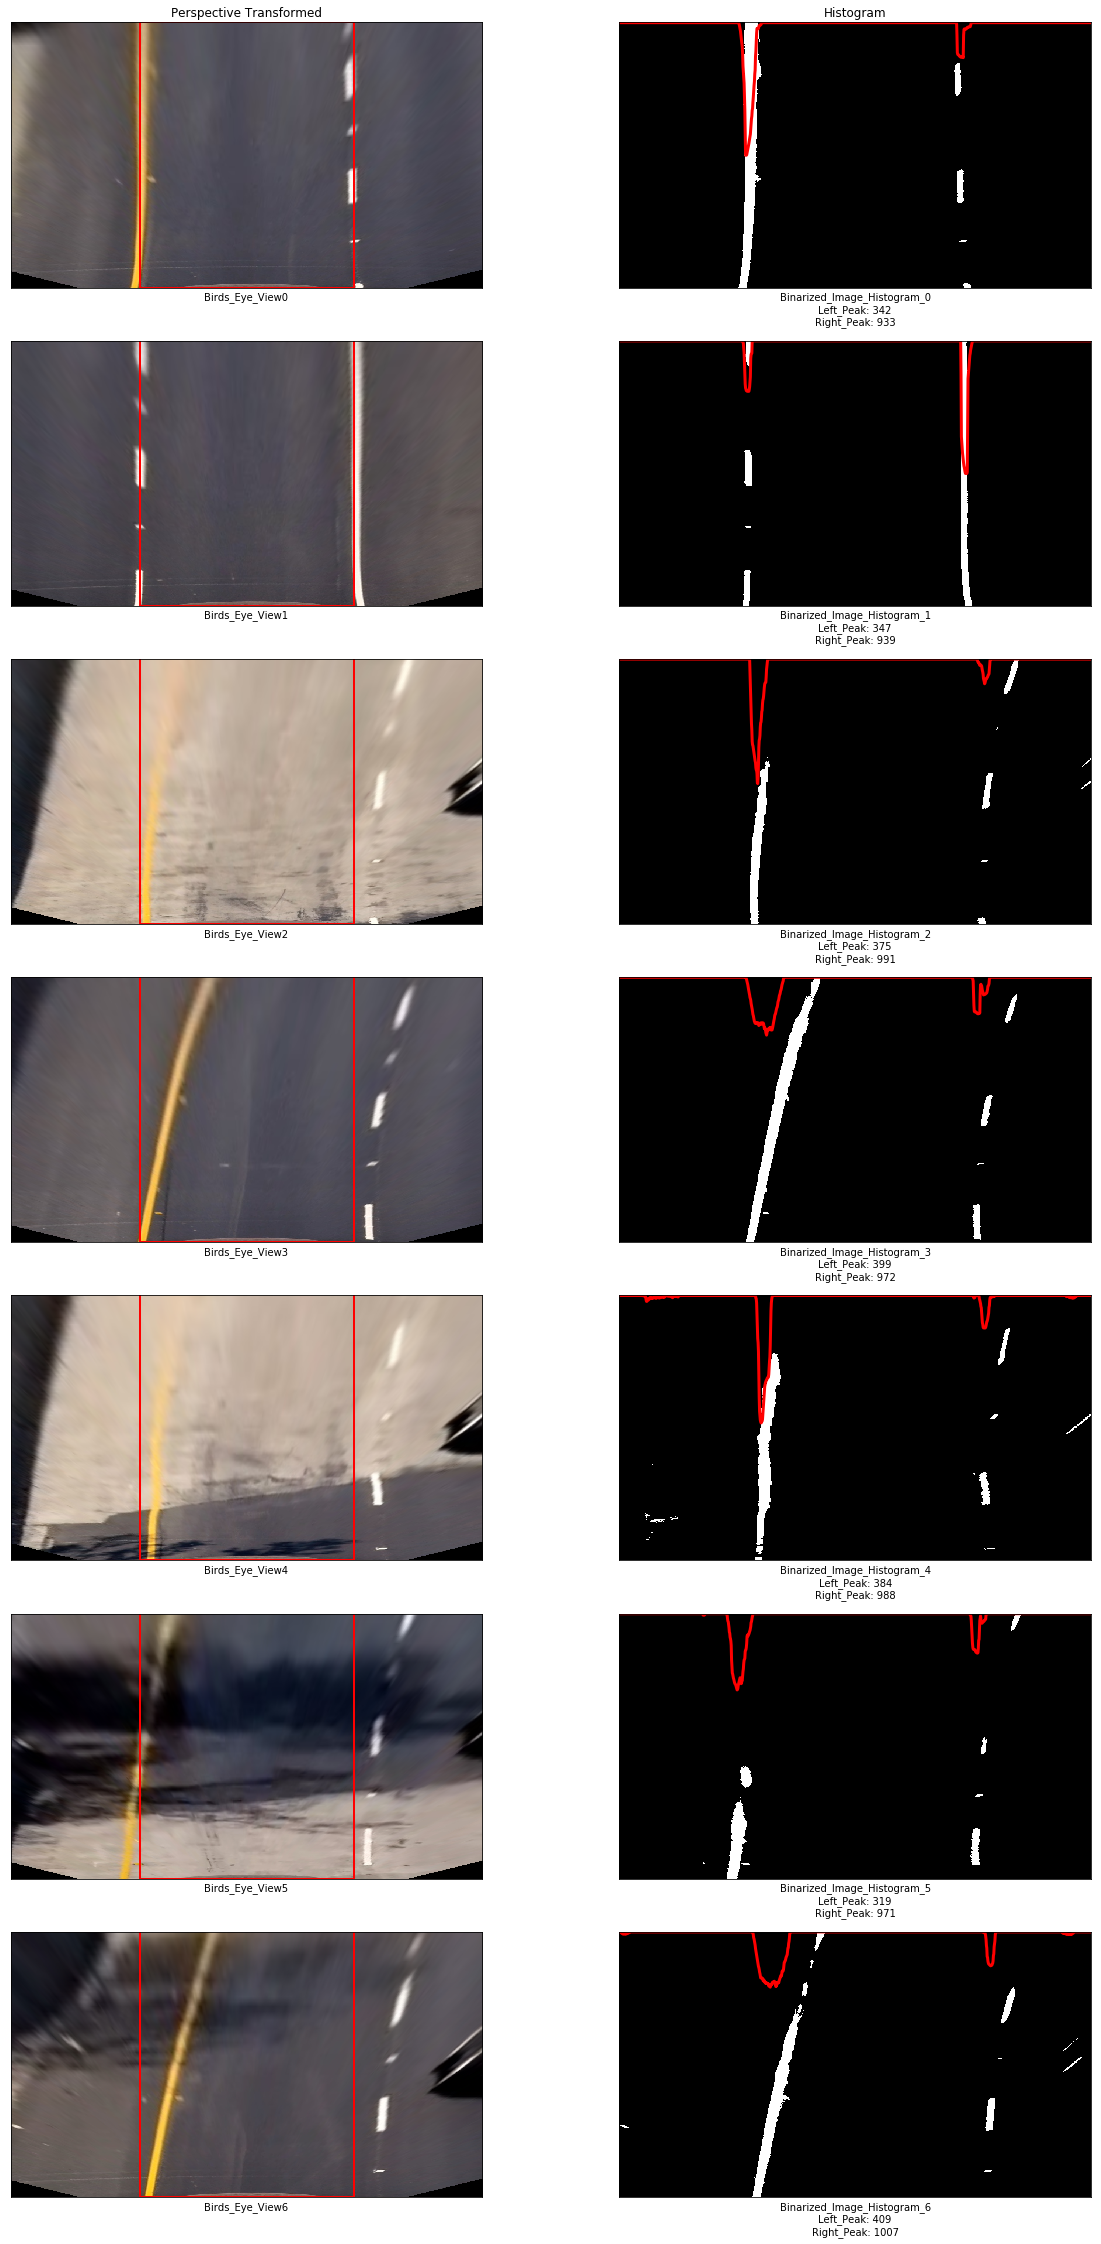

In [11]:
fig, axes = plt.subplots(nrows = len(images), ncols = 2, figsize = (20, 40))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for ax, col in zip(axes[0], ['Perspective Transformed', 'Histogram']):
    ax.set_title(col)
for i, ax in enumerate(axes.flat):
    image = mpimg.imread(images[c])
    undistorted = undistort(image)
    warped, warped_labelled, roi, image_labelled = perspective_transform(undistorted)
    binarized = binarize(warped)
    histogram = get_histogram(binarized)
    left_x_base, right_x_base = get_histogram_peaks(histogram)
    if i % 2 == 0:
        ax.imshow(warped_labelled)
        ax.set_xlabel('Birds_Eye_View' + str(c))
    if i % 2 == 1:
        ax.imshow(binarized, cmap = 'gray')
        ax.plot(histogram, linewidth = 3, color = 'red')
        ax.set_xlabel('Binarized_Image_Histogram_' + str(c) + '\nLeft_Peak: ' + str(left_x_base) + '\nRight_Peak: ' + str(right_x_base))
        c += 1
plt.show()

In [12]:
def get_window_boundaries(image, window, window_height, margin, left_x, right_x):
    win_y_low = image.shape[0] - (window + 1) * window_height
    win_y_high = image.shape[0] - window * window_height
    win_x_left_low = left_x - margin
    win_x_left_high = left_x + margin
    win_x_right_low = right_x - margin
    win_x_right_high = right_x + margin
    return win_y_low, win_y_high, win_x_left_low, win_x_left_high, win_x_right_low, win_x_right_high

In [13]:
def detect_bounding_boxes(binary_image, n_windows = 9, margin = 100, min_pix = 50):
    histogram = get_histogram(binary_image)
    left_x_base, right_x_base = get_histogram_peaks(histogram)
    output_image = np.dstack((binary_image, binary_image, binary_image)) * 255
    window_height = np.int(binary_image.shape[0] // n_windows)
    nonzero = binary_image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    left_x_current = left_x_base
    right_x_current = right_x_base
    left_lane_indices, right_lane_indices = [], []
    for window in range(n_windows):
        boundaries = get_window_boundaries(binary_image, window, window_height, margin, left_x_current, right_x_current)
        win_y_low, win_y_high, win_x_left_low, win_x_left_high, win_x_right_low, win_x_right_high = boundaries
        cv2.rectangle(output_image, (win_x_left_low, win_y_low), (win_x_left_high, win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(output_image, (win_x_right_low, win_y_low), (win_x_right_high, win_y_high), (0, 255, 0), 2)
        good_left_indices = ((nonzero_y >= win_y_low) &\
                             (nonzero_y < win_y_high) &\
                             (nonzero_x >= win_x_left_low) &\
                             (nonzero_x < win_x_left_high)).nonzero()[0]
        good_right_indices = ((nonzero_y >= win_y_low) &\
                              (nonzero_y < win_y_high) &\
                              (nonzero_x >= win_x_right_low) &\
                              (nonzero_x < win_x_right_high)).nonzero()[0]
        left_lane_indices.append(good_left_indices)
        right_lane_indices.append(good_right_indices)
        if len(good_left_indices) > min_pix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_indices]))
        if len(good_right_indices) > min_pix:        
            right_x_current = np.int(np.mean(nonzero_x[good_right_indices]))
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)
    left_x = nonzero_x[left_lane_indices]
    left_y = nonzero_y[left_lane_indices] 
    right_x = nonzero_x[right_lane_indices]
    right_y = nonzero_y[right_lane_indices]
    output_image[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
    output_image[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]
    return output_image, left_x, left_y, left_lane_indices, right_x, right_y, right_lane_indices

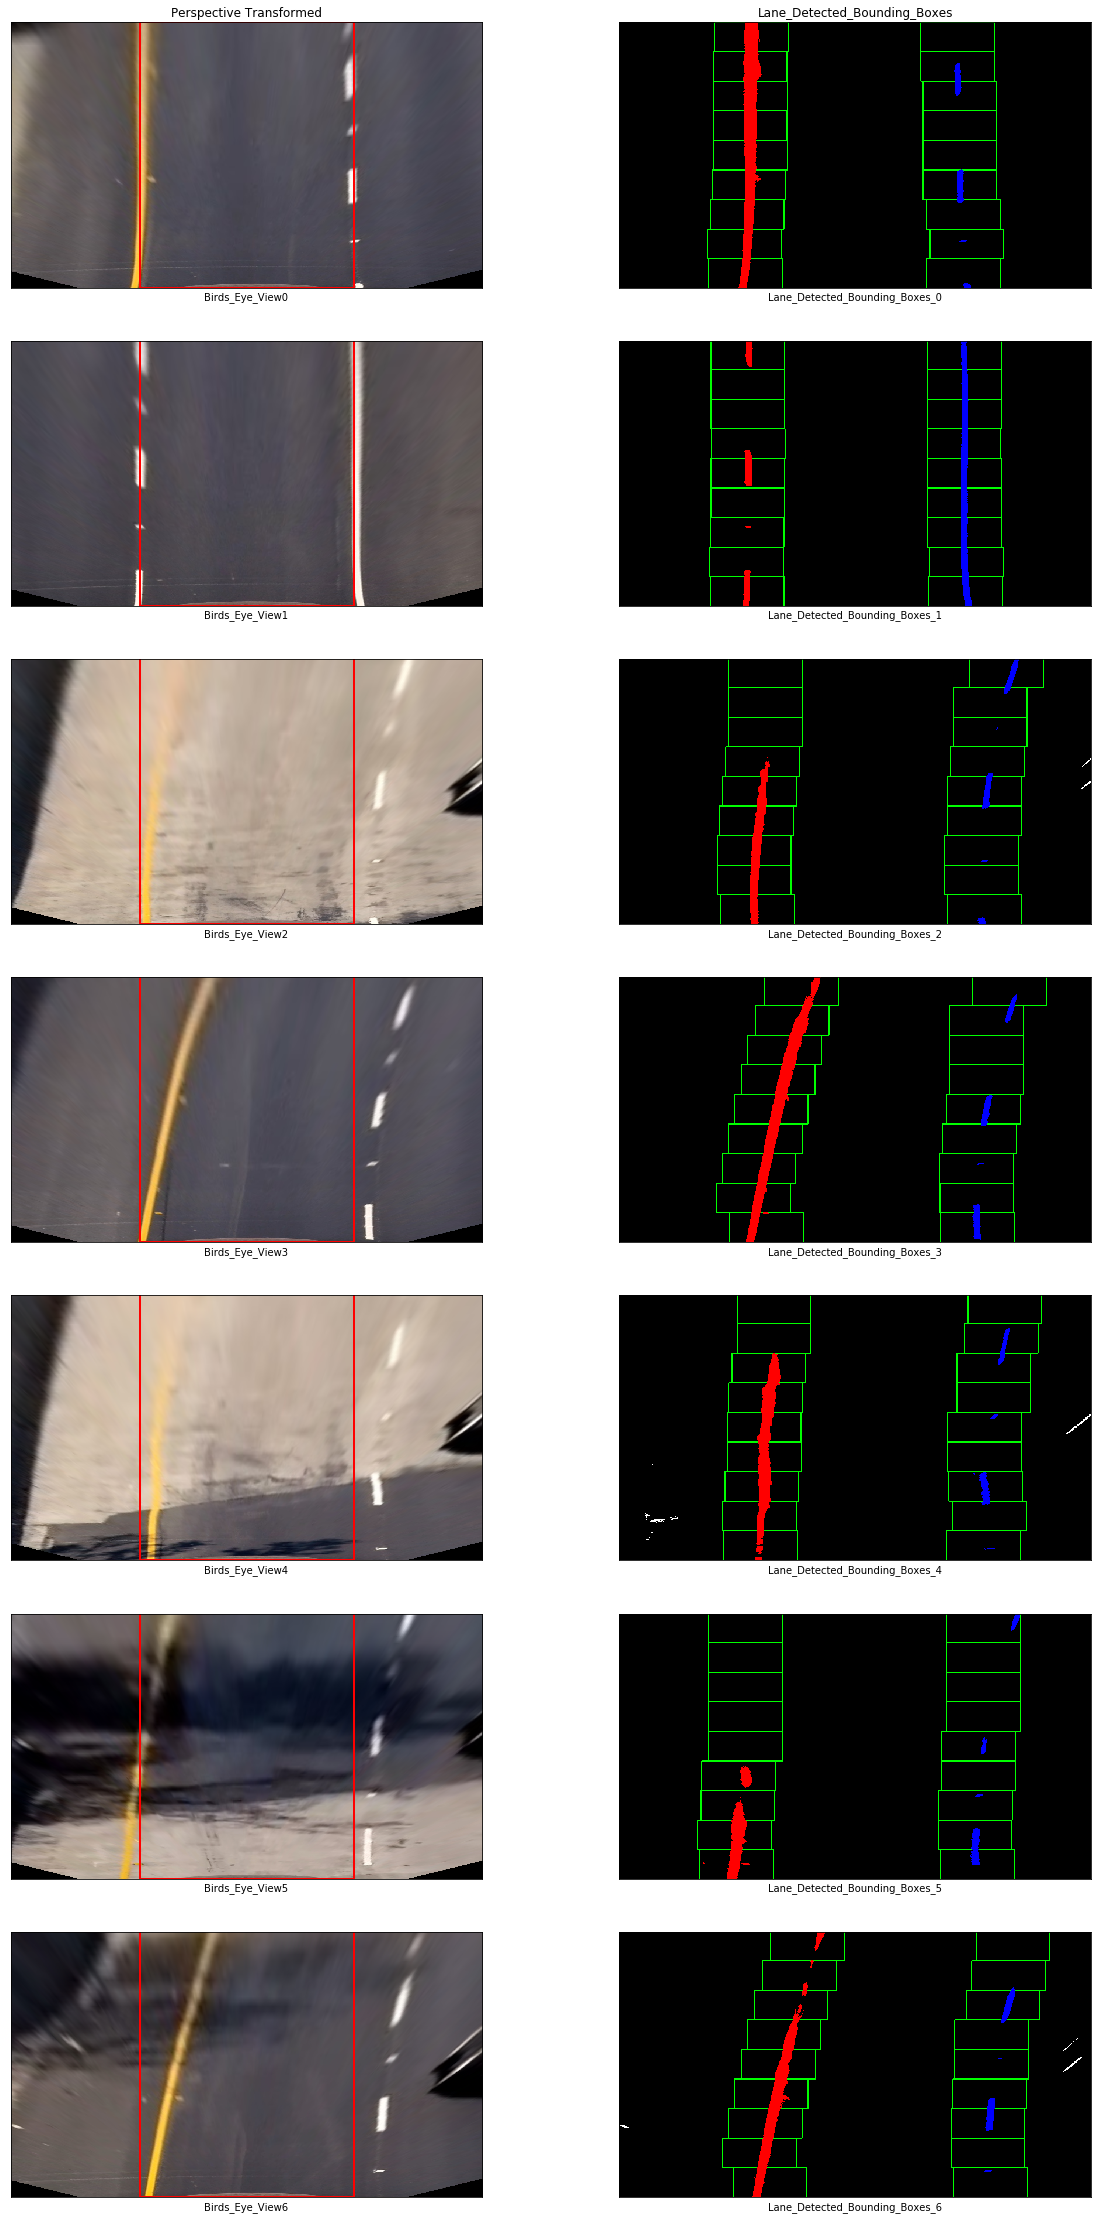

In [14]:
fig, axes = plt.subplots(nrows = len(images), ncols = 2, figsize = (20, 40))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for ax, col in zip(axes[0], ['Perspective Transformed', 'Lane_Detected_Bounding_Boxes']):
    ax.set_title(col)
for i, ax in enumerate(axes.flat):
    image = mpimg.imread(images[c])
    undistorted = undistort(image)
    warped, warped_labelled, roi, image_labelled = perspective_transform(undistorted)
    binarized = binarize(warped)
    output_image, left_x, left_y, left_lane_indices, right_x, right_y, right_lane_indices = detect_bounding_boxes(binarized)
    if i % 2 == 0:
        ax.imshow(warped_labelled)
        ax.set_xlabel('Birds_Eye_View' + str(c))
    if i % 2 == 1:
        ax.imshow(output_image)
        ax.set_xlabel('Lane_Detected_Bounding_Boxes_' + str(c))
        c += 1
plt.show()

In [15]:
def fit_polynomial(binary_image, left_x, left_y, right_x, right_y):
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    plot_y = np.linspace(0, binary_image.shape[0] - 1, binary_image.shape[0])
    left_fit_x = left_fit[0] * (plot_y ** 2) + left_fit[1] * plot_y + left_fit[2]
    right_fit_x = right_fit[0] * (plot_y ** 2) + right_fit[1] * plot_y + right_fit[2]
    return plot_y, left_fit_x, right_fit_x

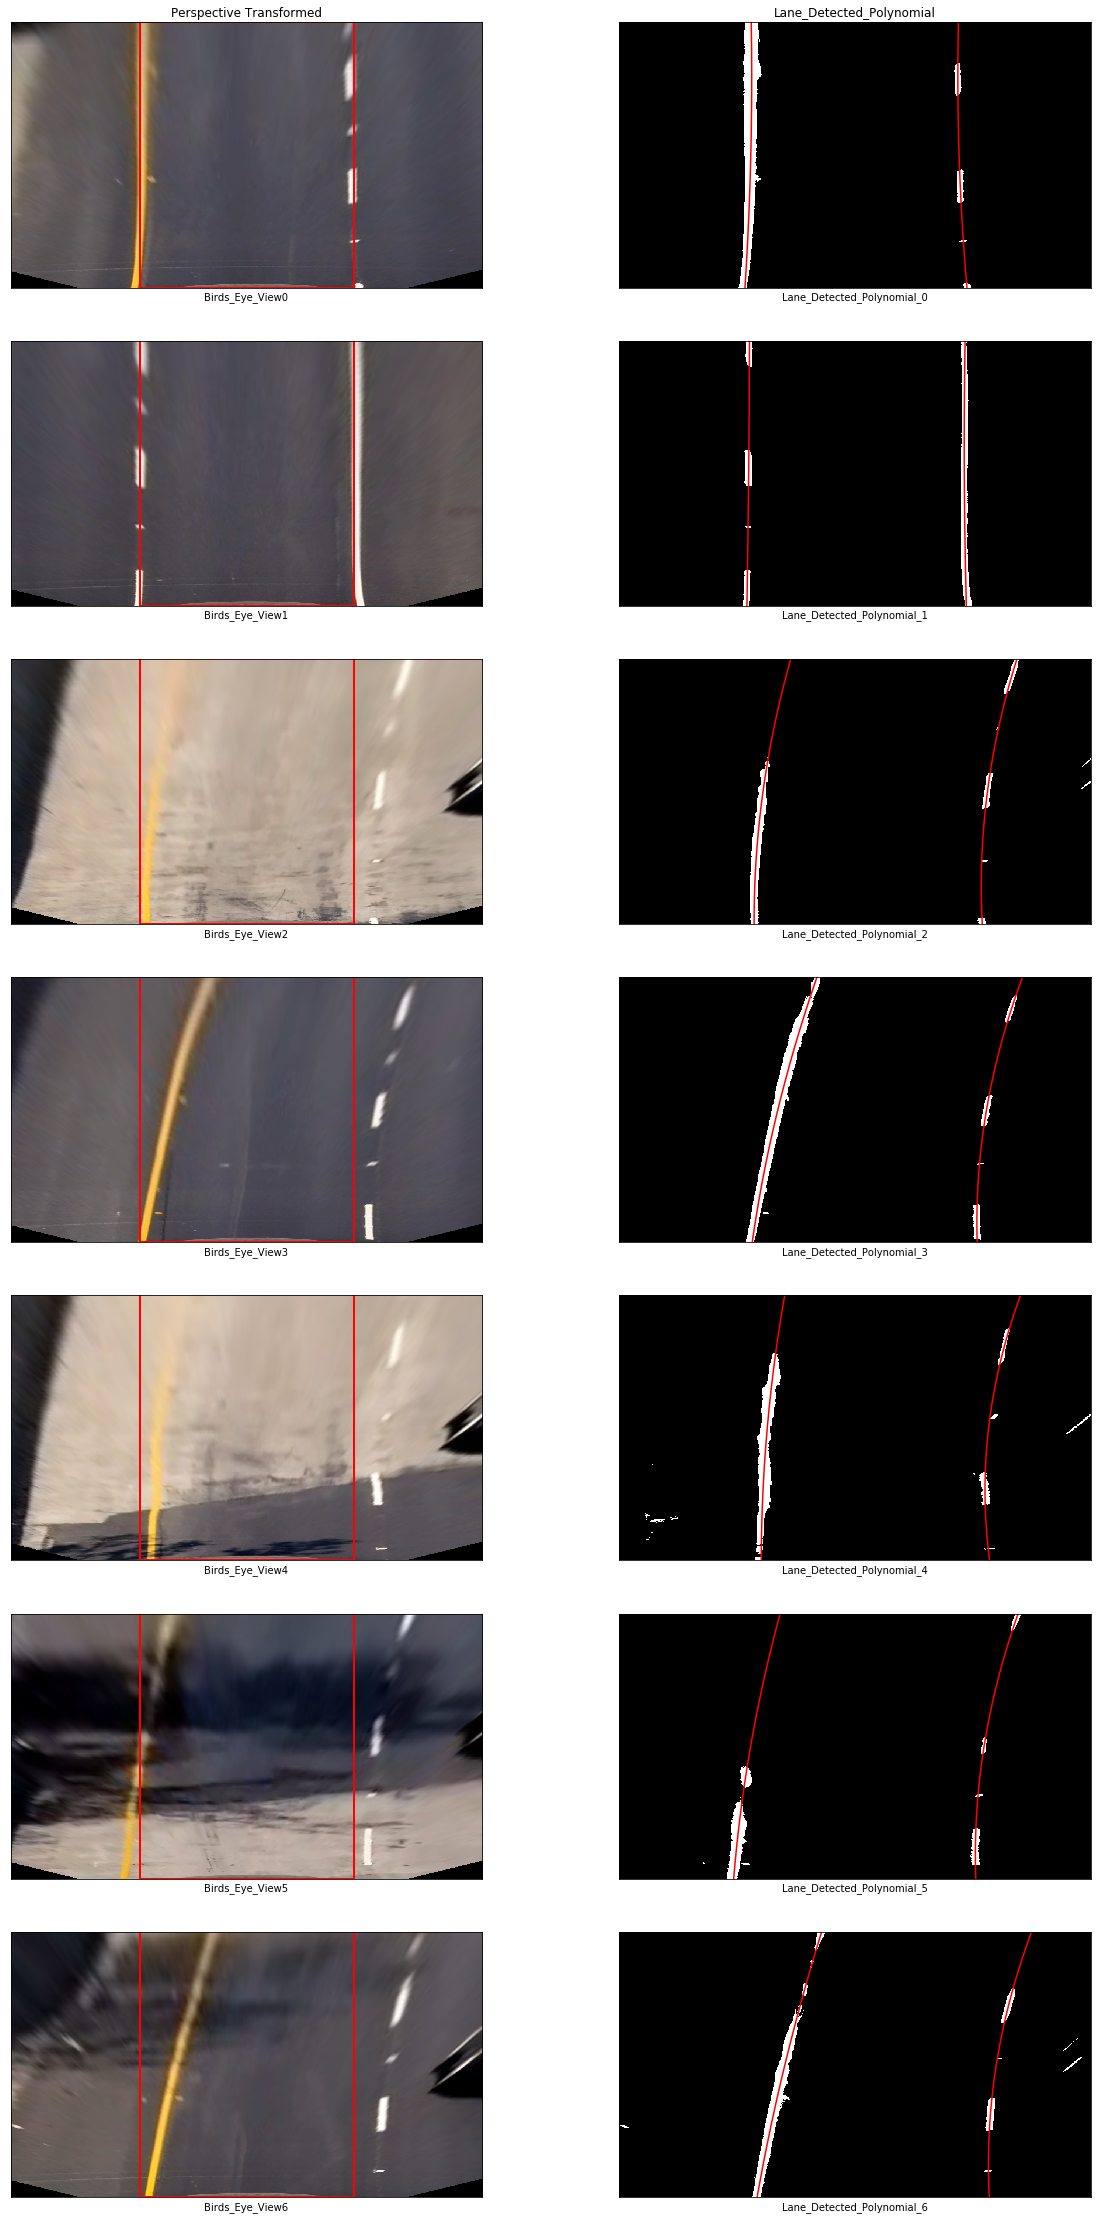

In [16]:
fig, axes = plt.subplots(nrows = len(images), ncols = 2, figsize = (20, 40))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for ax, col in zip(axes[0], ['Perspective Transformed', 'Lane_Detected_Polynomial']):
    ax.set_title(col)
for i, ax in enumerate(axes.flat):
    image = mpimg.imread(images[c])
    undistorted = undistort(image)
    warped, warped_labelled, roi, image_labelled = perspective_transform(undistorted)
    binarized = binarize(warped)
    output_image, left_x, left_y, left_lane_indices, right_x, right_y, right_lane_indices = detect_bounding_boxes(binarized)
    plot_y, left_fit_x, right_fit_x = fit_polynomial(binarized, left_x, left_y, right_x, right_y)
    if i % 2 == 0:
        ax.imshow(warped_labelled)
        ax.set_xlabel('Birds_Eye_View' + str(c))
    if i % 2 == 1:
        ax.imshow(binarized, cmap = 'gray')
        ax.plot(left_fit_x, plot_y, color = 'red')
        ax.plot(right_fit_x, plot_y, color = 'red')
#         ax.xlim(0, 1280)
#         ax.ylim(720, 0)
        ax.set_xlabel('Lane_Detected_Polynomial_' + str(c))
        c += 1
plt.show()